### 📘 Lesson 10: GRDC Data

<div style="display: flex; align-items: center; justify-content: space-between;">
  <div>
    <h3>Course presenters</h3>
    <ul>
      <li><strong>Priyesh Gosai</strong> - Energy Systems Modeler and Training Coordinator</li>
    </ul>
  </div>
  <div>
    <a href="https://openenergytransition.org/index.html">
      <img src="https://openenergytransition.org/assets/img/oet-logo-red-n-subtitle.png" height="60" alt="OET">
    </a>
  </div>
</div>


#### 🎯 Learning Objectives  



* Read data from the GRDC database. 
---

**Setup Environment**

In [ ]:
# @title "Mount Google Drive and Set Working Directory"

from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Set FOLDER and change to the working directory in one step
FOLDER = 'ich-modeling-2025'
os.chdir(f'/content/drive/MyDrive/{FOLDER}')

# Confirm the current working directory
print("Current working directory:", os.getcwd())

In [ ]:
# @title Install latest version of PyPSA with Excel support

import os
from IPython.display import clear_output

# Install required packages
os.system("pip install -q pypsa")
os.system("pip install -q 'pypsa[excel]'")
os.system("pip install -q folium mapclassify")

# Clear the output after installation
clear_output()

# Notify the user
print("✅ All required packages have been installed.\n"
      "💡 To comment this cell, select all the text and press `Ctrl + /`.")

### 📄 **Case Study**

You have been provided

* The file `data/power_pool_data/rucana/GRDC-Daily.nc` that was downloaded for the Rucana measurement station from the GRDC data poral. 
* Read the data, plot the flows and create a table for all relevant climate years. 


### Explore Data

In [16]:
import xarray as xr
import numpy as np
import pandas as pd

In [17]:
file_name = "data/power_pool_data/rucana/GRDC-Daily.nc"

ds = xr.open_dataset(file_name, decode_times=False)

In [18]:
time_raw = ds.time.values

# Convert time to datetime64
time_converted = np.array(time_raw, dtype="timedelta64[D]") + np.datetime64("1700-01-01")

In [19]:
runoff = ds.runoff_mean.isel(id=0).values
runoff

array([46.64, 45.72, 44.67, ..., 38.7 , 40.81, 41.67],
      shape=(21814,), dtype=float32)

In [20]:
# Create daily time series DataFrame
runoff_df = pd.DataFrame({
    "date": time_converted,
    "runoff_m3s": runoff
}).set_index("date")

<Axes: xlabel='date'>

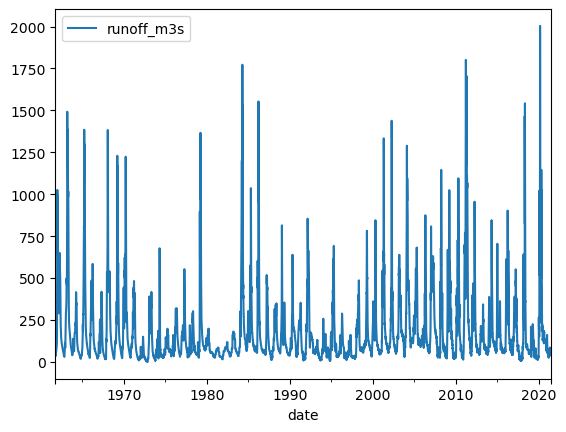

In [22]:
runoff_df.plot()

### Functions

In [1]:
import xarray as xr
import pandas as pd
import numpy as np

def extract_hourly_runoff_by_year(filename, missing_threshold=24):
    """
    Processes a GRDC NetCDF file and returns a pivoted, cleaned DataFrame of hourly runoff.
    
    Parameters:
        filename (str): Path to the NetCDF file.
        missing_threshold (int): Maximum number of NaNs allowed per year.

    Returns:
        pd.DataFrame: DataFrame indexed by hour of year, with each column representing a year.
    """
    # Load dataset with decode_times=False to manually handle time
    ds = xr.open_dataset(filename, decode_times=False)
    
    # Extract variables
    runoff = ds["runoff_mean"].isel(id=0).values
    time_raw = ds["time"].values
    runoff = np.where(runoff == -999.0, np.nan, runoff)

    # Convert time to datetime64
    time_converted = np.array(time_raw, dtype="timedelta64[D]") + np.datetime64("1700-01-01")

    # Create daily time series DataFrame
    runoff_df = pd.DataFrame({
        "date": time_converted,
        "runoff_m3s": runoff
    }).set_index("date")

    # Resample to hourly and apply forward fill
    runoff_hourly = runoff_df.resample("h").ffill()

    # Smooth with centered 24-hour moving average and fill edges
    runoff_hourly = runoff_hourly.rolling(window=24, center=True, win_type="boxcar").mean()
    runoff_hourly = runoff_hourly.ffill().bfill()

    # Drop leap days
    runoff_hourly = runoff_hourly[~((runoff_hourly.index.month == 2) & (runoff_hourly.index.day == 29))]

    # Add year and hour-of-year
    df = runoff_hourly.copy()
    df["year"] = df.index.year
    df["hour_of_year"] = ((df.index.dayofyear - 1) * 24) + df.index.hour

    # Pivot to [hour_of_year x year]
    pivot = df.pivot(index="hour_of_year", columns="year", values="runoff_m3s")

    # Drop years with more than `missing_threshold` NaNs
    pivot = pivot.dropna(axis=1, thresh=pivot.shape[0] - missing_threshold)

    # Fill remaining missing data
    pivot = pivot.ffill().bfill()

    # Drop last 24 hours to standardize length
    return pivot.iloc[:-23]


In [2]:
def check_runoff_data_cleanliness(df):
    """
    Checks basic data quality metrics for a pivoted runoff dataset.
    
    Parameters:
        df (pd.DataFrame): DataFrame with hour_of_year as index and years as columns.
    """
    print("✅ DataFrame Shape:", df.shape)
    print()

    # Missing data check
    total_nans = df.isna().sum().sum()
    print("🔍 Total missing values:", total_nans)

    if total_nans > 0:
        print("⚠️ Missing values per year (top 5):")
        print(df.isna().sum().sort_values(ascending=False).head())
        print()
    else:
        print("✅ No missing values.")
        print()

    # Expected hourly rows (after dropping leap day and last day)
    expected_hours = 8760 - 24 - 24
    if df.shape[0] != expected_hours:
        print(f"⚠️ Unexpected number of rows: {df.shape[0]} (expected: {expected_hours})")
    else:
        print(f"📆 All years span expected {expected_hours} hourly steps.")

    print("📅 Year range:", df.columns.min(), "to", df.columns.max())
    print("📈 Value range (runoff in m³/s):")
    print("Min:", df.min().min())
    print("Max:", df.max().max())
    print("Mean:", df.mean().mean())


### View and extract data

In [3]:
file_path = "data/power_pool_data/rucana/GRDC-Daily.nc"
output_path = 'data/power_pool_data/rucana/rucana.csv'

In [4]:
df_river = extract_hourly_runoff_by_year(file_path)


In [5]:
check_runoff_data_cleanliness(df_river)

✅ DataFrame Shape: (8761, 59)

🔍 Total missing values: 0
✅ No missing values.

⚠️ Unexpected number of rows: 8761 (expected: 8712)
📅 Year range: 1962 to 2020
📈 Value range (runoff in m³/s):
Min: 0.0
Max: 2003.5999755859375
Mean: 178.8488685776716


In [6]:
import plotly.graph_objects as go

# Create a Plotly figure
fig = go.Figure()

# Add one line per year
for year in df_river.columns:
    fig.add_trace(go.Scatter(
        x=df_river.index,
        y=df_river[year],
        mode='lines',
        name=str(year),
        line=dict(width=1)
    ))

# Update layout
fig.update_layout(
    title="Hourly Runoff by Year",
    xaxis_title="Hour of Year",
    yaxis_title="Runoff (m³/s)",
    template="plotly_white",
    height=600,
    width=1000,
    showlegend=False  # Set True if legend is desired
)

fig.show()


In [7]:
df_river.to_csv(output_path)

---